# Comparación de PHL con otros métodos de selección de instancias

In [107]:
import pandas as pd
import numpy as np
import time
import os
import sys

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import f1_score, accuracy_score

from data_reduction.representativeness import find_epsilon

sys.path.append('../')
from my_dataset_reduction import phl_selection, srs_selection, clc_selection, drop3_selection, cnn_selection

import seaborn as sns
import matplotlib.pyplot as plt


dbpath = '../datasets/dry+bean+dataset/DryBeanDataset/Dry_Bean_Dataset.xlsx'
target = 'Class'


SEED = 2025
np.random.seed(SEED)

PROFILING = False # False para tomar todo el dataset, True para tomar una muestra para hacer pruebas rápidas
results_folder = '../results/drybeans/' if not PROFILING else '../results/drybeans_profiling/'

# Check if the results folder exists, if not create it
if not os.path.exists(results_folder):
    os.makedirs(results_folder)

In [108]:
df = pd.read_excel(dbpath, )

pd.set_option('display.max_columns', None)
print("Tamaño del dataset: ", df.shape)
df.describe()

Tamaño del dataset:  (13611, 17)


,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4
count,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000
mean,53048.284549,855.283459,320.141867,202.270714,1.583242,0.750895,53768.200206,253.064220,0.749733,0.987143,0.873282,0.799864,0.006564,0.001716,0.643590,0.995063
std,29324.095717,214.289696,85.694186,44.970091,0.246678,0.092002,29774.915817,59.177120,0.049086,0.004660,0.059520,0.061713,0.001128,0.000596,0.098996,0.004366
min,20420.000000,524.736000,183.601165,122.512653,1.024868,0.218951,20684.000000,161.243764,0.555315,0.919246,0.489618,0.640577,0.002778,0.000564,0.410339,0.947687
25%,36328.000000,703.523500,253.303633,175.848170,1.432307,0.715928,36714.500000,215.068003,0.718634,0.985670,0.832096,0.762469,0.005900,0.001154,0.581359,0.993703
50%,44652.000000,794.941000,296.883367,192.431733,1.551124,0.764441,45178.000000,238.438026,0.759859,0.988283,0.883157,0.801277,0.006645,0.001694,0.642044,0.996386
75%,61332.000000,977.213000,376.495012,217.031741,1.707109,0.810466,62294.000000,279.446467,0.786851,0.990013,0.916869,0.834270,0.007271,0.002170,0.696006,0.997883
max,254616.000000,1985.370000,738.860153,460.198497,2.430306,0.911423,263261.000000,569.374358,0.866195,0.994677,0.990685,0.987303,0.010451,0.003665,0.974767,0.999733


In [109]:
df.head()

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
0,28395,610.291,208.178117,173.888747,1.197191,0.549812,28715,190.141097,0.763923,0.988856,0.958027,0.913358,0.007332,0.003147,0.834222,0.998724,SEKER
1,28734,638.018,200.524796,182.734419,1.097356,0.411785,29172,191.272750,0.783968,0.984986,0.887034,0.953861,0.006979,0.003564,0.909851,0.998430,SEKER
2,29380,624.110,212.826130,175.931143,1.209713,0.562727,29690,193.410904,0.778113,0.989559,0.947849,0.908774,0.007244,0.003048,0.825871,0.999066,SEKER
3,30008,645.884,210.557999,182.516516,1.153638,0.498616,30724,195.467062,0.782681,0.976696,0.903936,0.928329,0.007017,0.003215,0.861794,0.994199,SEKER
4,30140,620.134,201.847882,190.279279,1.060798,0.333680,30417,195.896503,0.773098,0.990893,0.984877,0.970516,0.006697,0.003665,0.941900,0.999166,SEKER


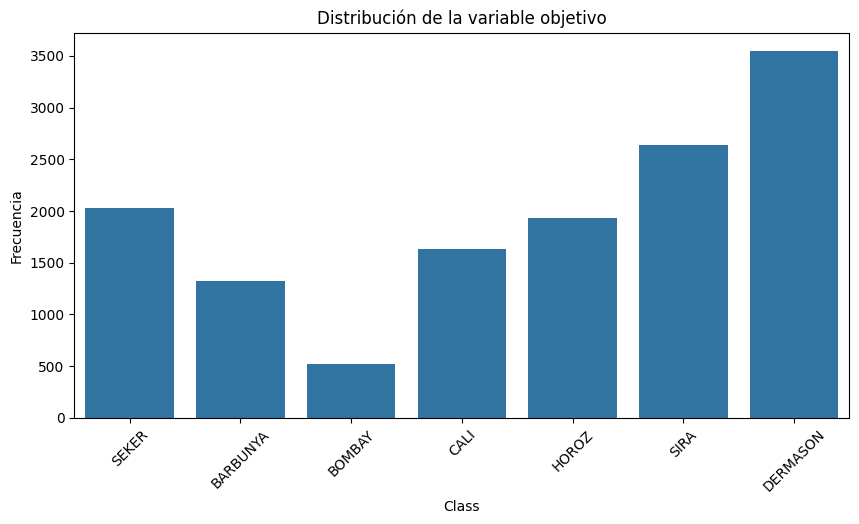

In [110]:
# Show bar plot of the target variable
plt.figure(figsize=(10, 5))
sns.countplot(x=target, data=df)
plt.title('Distribución de la variable objetivo')
plt.xlabel(target)
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.show()

In [111]:
# Train test split
X = df.drop(columns=[target])
X = np.array(X)

# Convertir la columna target a entero
if not pd.api.types.is_integer_dtype(df[target]):
    le = LabelEncoder()
    y = le.fit_transform(df[target])
else:
    y = df[target].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

In [112]:
# Modelos ML
knn = KNeighborsClassifier(n_neighbors=3, n_jobs=-1)
rf = RandomForestClassifier(n_estimators=100, random_state=SEED)
xgb = XGBClassifier(n_estimators=100, random_state=SEED)

In [113]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Test de hiperparámetros de PHL

In [114]:
phl_results = pd.read_csv(results_folder + '/phl_results.csv')

In [115]:
# Drop rows with delta greater than 0.05
# phl_results = phl_results[phl_results['delta'] <= 0.05]

In [116]:
phl_results

,model,reduction_method,mode,dimensions,max_dimension,percentage,delta,reduction_ratio,representativeness,accuracy,f1,training_time,reduction_time
0,KNN,PHL,representative,restrictedDim,0,0.05,0.0005,0.050055,11.428036,0.888358,0.888403,0.000692,0.740062
1,KNN,PHL,representative,restrictedDim,0,0.10,0.0005,0.100018,13.149350,0.899743,0.899933,0.000745,0.747014
2,KNN,PHL,representative,restrictedDim,0,0.20,0.0005,0.200037,3.732432,0.905986,0.906291,0.000543,0.739757
3,KNN,PHL,representative,restrictedDim,0,0.30,0.0005,0.299871,10.841108,0.908924,0.909168,0.000567,0.739959
4,KNN,PHL,representative,restrictedDim,0,0.50,0.0005,0.500000,11.926139,0.916636,0.916732,0.000674,0.740117
...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,XGB,PHL,vital,restrictedDim,0,0.20,0.1000,0.200037,11.428036,0.843188,0.841161,0.291266,2043.972830
248,XGB,PHL,vital,restrictedDim,0,0.30,0.1000,0.299871,11.428036,0.851267,0.851494,0.327488,2043.972969
249,XGB,PHL,vital,restrictedDim,0,0.50,0.1000,0.500000,11.428036,0.901579,0.902089,0.397759,2043.973297
250,XGB,PHL,vital,restrictedDim,0,0.75,0.1000,0.750000,11.428036,0.920676,0.920794,0.449156,2043.973802


In [117]:
# Print hyperparameter grid
print("Hyperparameter grid for PHL selection:")
hyperparameter_columns = [
    'model', 'reduction_method', 'mode', 'delta', 'percentage'
]
for column in hyperparameter_columns:
        print(f"{column}: {phl_results[column].unique()}")

print("Dimensions: ", phl_results[['dimensions', 'max_dimension']].drop_duplicates().values)

Hyperparameter grid for PHL selection:
model: ['KNN' 'RF' 'XGB']
reduction_method: ['PHL']
mode: ['representative' 'vital']
delta: [0.0005 0.001  0.005  0.01   0.05   0.1   ]
percentage: [0.05 0.1  0.2  0.3  0.5  0.75 0.9 ]
Dimensions:  [['restrictedDim' 0]]


In [118]:
arr = np.array([0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1])
np.where(arr == 1)[0].shape[0]

5

In [119]:
# Get row with maximum accuracy for each model, perc, mode, dimensions and max_dimension
def get_best_row(df, model, perc):
    filtered_df = df[
        (df['model'] == model) &
        (df['percentage'] == perc)]
    if not filtered_df.empty:
        return filtered_df.loc[filtered_df['accuracy'].idxmax()]
    return None

# Show df with best metrics
def show_best_metrics(df):
    best_df = pd.DataFrame()
    for model in df['model'].unique():
        for perc in df['percentage'].unique():
            best_row = get_best_row(df, model, perc)
            if best_row is not None:
                best_df = best_df.append(best_row, ignore_index=True)
    return best_df

best_df = show_best_metrics(phl_results)
best_df

# Reorder columns
best_df = best_df[['model', 'percentage', 'mode', 'dimensions', 'max_dimension', 'delta', 'accuracy', 'f1', 'training_time', 'reduction_time']]
best_df

,model,percentage,mode,dimensions,max_dimension,delta,accuracy,f1,training_time,reduction_time
0,KNN,0.05,vital,restrictedDim,0.0,0.0005,0.905252,0.905699,0.000457,0.739500
1,KNN,0.10,vital,restrictedDim,0.0,0.0050,0.907822,0.908103,0.000487,0.736347
2,KNN,0.20,vital,restrictedDim,0.0,0.0005,0.914065,0.914333,0.000537,0.739689
3,KNN,0.30,vital,restrictedDim,0.0,0.0005,0.914433,0.914672,0.000572,0.739797
4,KNN,0.50,vital,restrictedDim,0.0,0.0100,0.919207,0.919372,0.000645,0.803262
5,KNN,0.75,representative,restrictedDim,0.0,0.0005,0.918472,0.918659,0.000829,0.740658
6,KNN,0.90,representative,restrictedDim,0.0,0.0005,0.921043,0.921221,0.000850,0.740893
7,RF,0.05,representative,restrictedDim,0.0,0.0010,0.907455,0.907530,0.145190,0.653349
8,RF,0.10,vital,restrictedDim,0.0,0.0005,0.912964,0.913202,0.248168,0.646545
9,RF,0.20,representative,restrictedDim,0.0,0.0005,0.914800,0.914830,0.502650,0.646669


In [120]:
best_df[best_df['mode'] == 'representative']

,model,percentage,mode,dimensions,max_dimension,delta,accuracy,f1,training_time,reduction_time
5,KNN,0.75,representative,restrictedDim,0.0,0.0005,0.918472,0.918659,0.000829,0.740658
6,KNN,0.90,representative,restrictedDim,0.0,0.0005,0.921043,0.921221,0.000850,0.740893
7,RF,0.05,representative,restrictedDim,0.0,0.0010,0.907455,0.907530,0.145190,0.653349
9,RF,0.20,representative,restrictedDim,0.0,0.0005,0.914800,0.914830,0.502650,0.646669
12,RF,0.75,representative,restrictedDim,0.0,0.0050,0.922879,0.922914,2.331632,0.676088
14,XGB,0.05,representative,restrictedDim,0.0,0.0005,0.910026,0.909942,0.153618,0.719693
15,XGB,0.10,representative,restrictedDim,0.0,0.0100,0.915534,0.915692,0.187568,0.803699
17,XGB,0.30,representative,restrictedDim,0.0,0.0005,0.919574,0.919637,0.316520,0.719481
18,XGB,0.50,representative,restrictedDim,0.0,0.0005,0.922512,0.922524,0.389865,0.719802
19,XGB,0.75,representative,restrictedDim,0.0,0.0010,0.924348,0.924391,0.454750,0.718044


In [121]:
best_df[best_df['mode'] == 'vital']

,model,percentage,mode,dimensions,max_dimension,delta,accuracy,f1,training_time,reduction_time
0,KNN,0.05,vital,restrictedDim,0.0,0.0005,0.905252,0.905699,0.000457,0.739500
1,KNN,0.10,vital,restrictedDim,0.0,0.0050,0.907822,0.908103,0.000487,0.736347
2,KNN,0.20,vital,restrictedDim,0.0,0.0005,0.914065,0.914333,0.000537,0.739689
3,KNN,0.30,vital,restrictedDim,0.0,0.0005,0.914433,0.914672,0.000572,0.739797
4,KNN,0.50,vital,restrictedDim,0.0,0.0100,0.919207,0.919372,0.000645,0.803262
8,RF,0.10,vital,restrictedDim,0.0,0.0005,0.912964,0.913202,0.248168,0.646545
10,RF,0.30,vital,restrictedDim,0.0,0.0005,0.918105,0.918082,0.794721,0.646847
11,RF,0.50,vital,restrictedDim,0.0,0.0100,0.921410,0.921531,1.421155,0.733097
13,RF,0.90,vital,restrictedDim,0.0,0.0010,0.922512,0.922616,2.957483,0.654193
16,XGB,0.20,vital,restrictedDim,0.0,0.0050,0.918105,0.918026,0.275689,0.741035


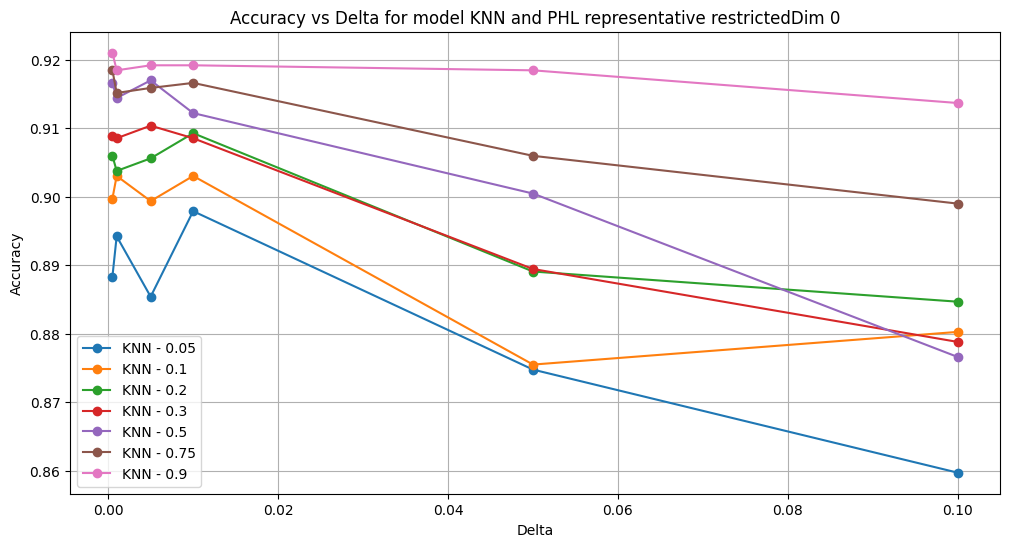

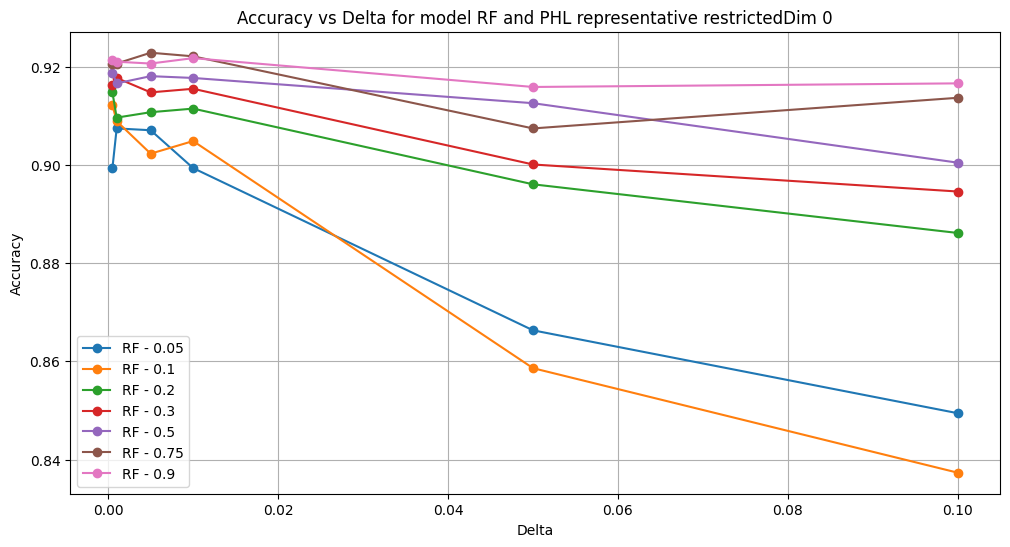

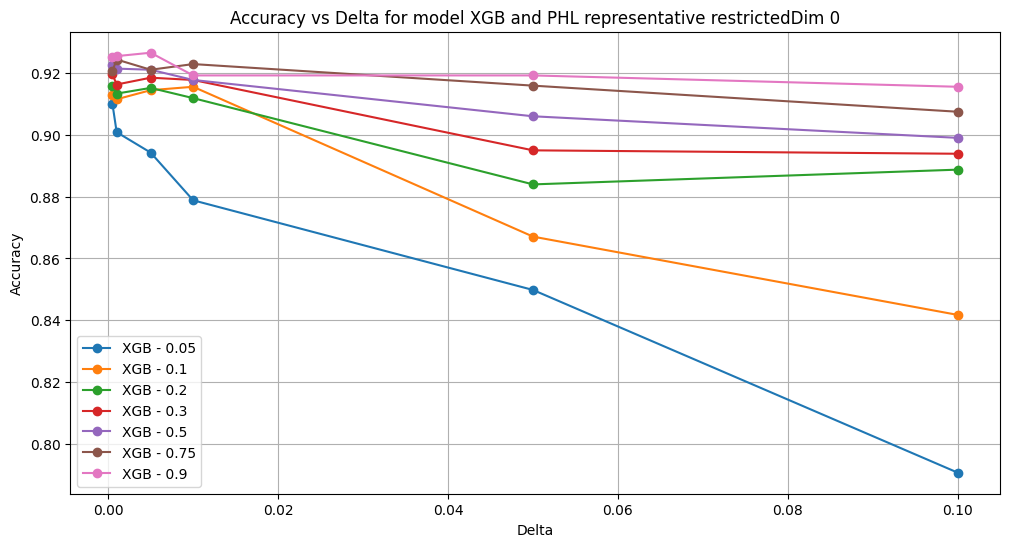

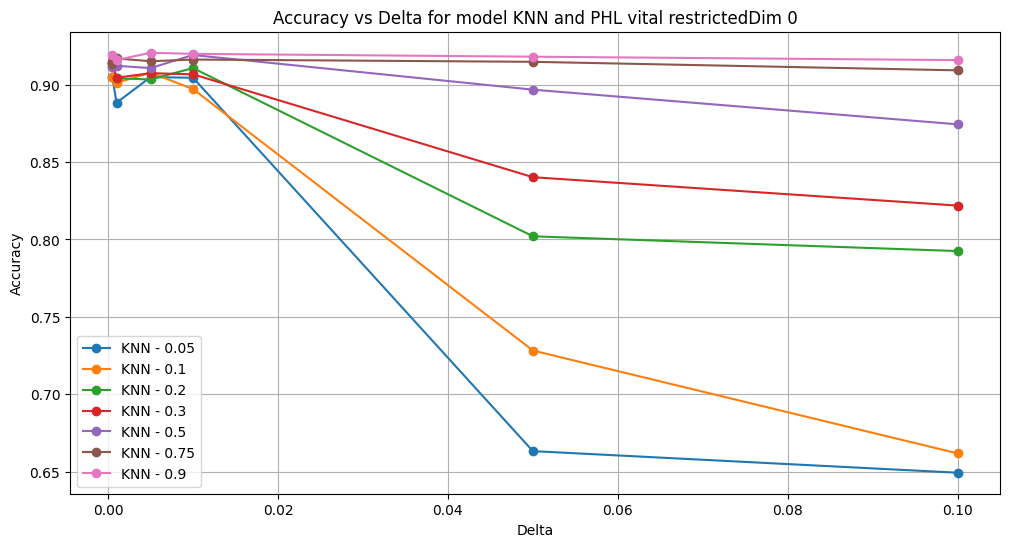

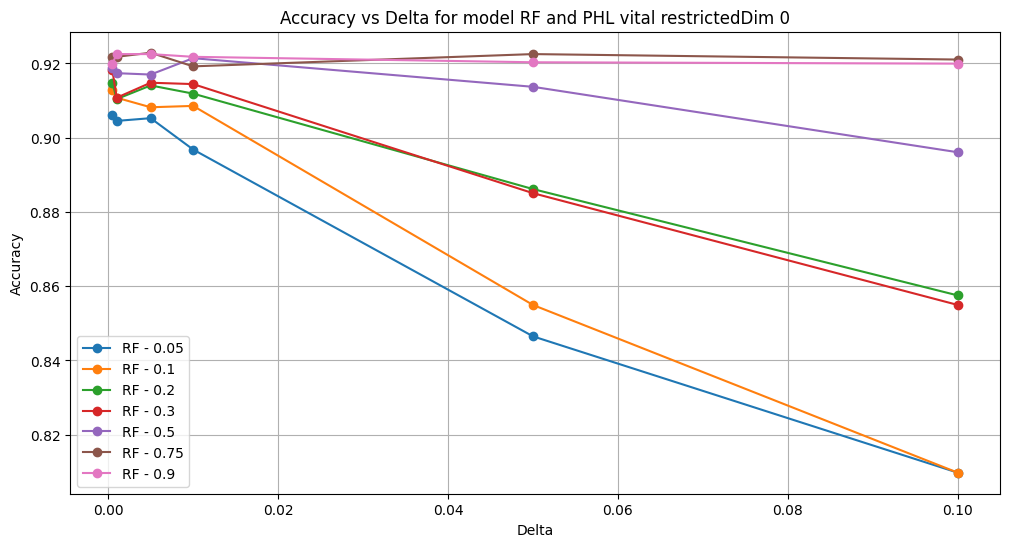

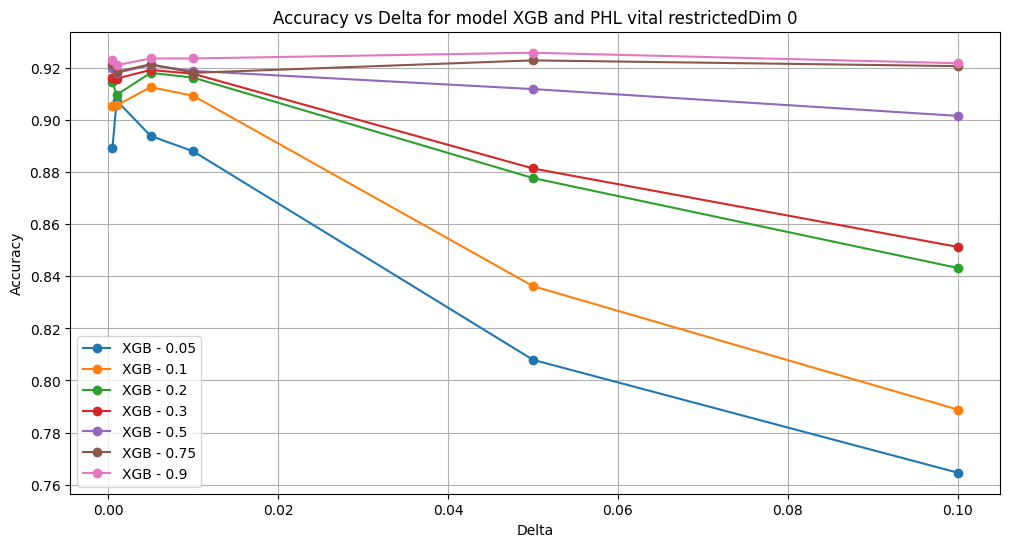

In [122]:
# Show accuracy vs delta for each model
for mode in phl_results['mode'].unique():
    for dimension in phl_results['max_dimension'].unique():
        for scoring_version in phl_results['dimensions'].unique():
            for model_name in phl_results['model'].unique():
                plt.figure(figsize=(12, 6))
                for percentage in phl_results['percentage'].unique():
                    plt.plot(phl_results[(phl_results['model'] == model_name) & 
                                         (phl_results['mode'] == mode) & 
                                         (phl_results['dimensions'] == scoring_version) & 
                                         (phl_results['max_dimension'] == dimension) & 
                                         (phl_results['percentage'] == percentage)]
                                         ['delta'],
                            phl_results[(phl_results['model'] == model_name) & 
                                    (phl_results['percentage'] == percentage) &
                                    (phl_results['mode'] == mode) & 
                                    (phl_results['dimensions'] == scoring_version) & 
                                    (phl_results['max_dimension'] == dimension)]
                                    ['accuracy'],
                        label=f'{model_name} - {percentage}', marker='o')
                plt.title(f'Accuracy vs Delta for model {model_name} and PHL {mode} {scoring_version} {dimension}')
                plt.xlabel('Delta')
                plt.ylabel('Accuracy')
                plt.legend()
                plt.grid()
            plt.savefig(f'{results_folder}/accuracy_vs_delta_{model_name}_{mode}_{scoring_version}_{dimension}.png')
            plt.show()

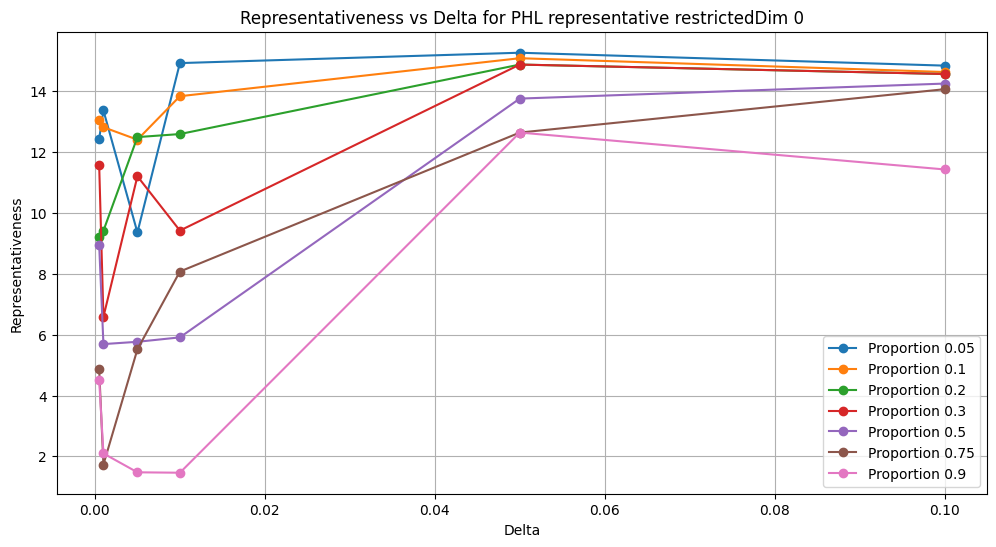

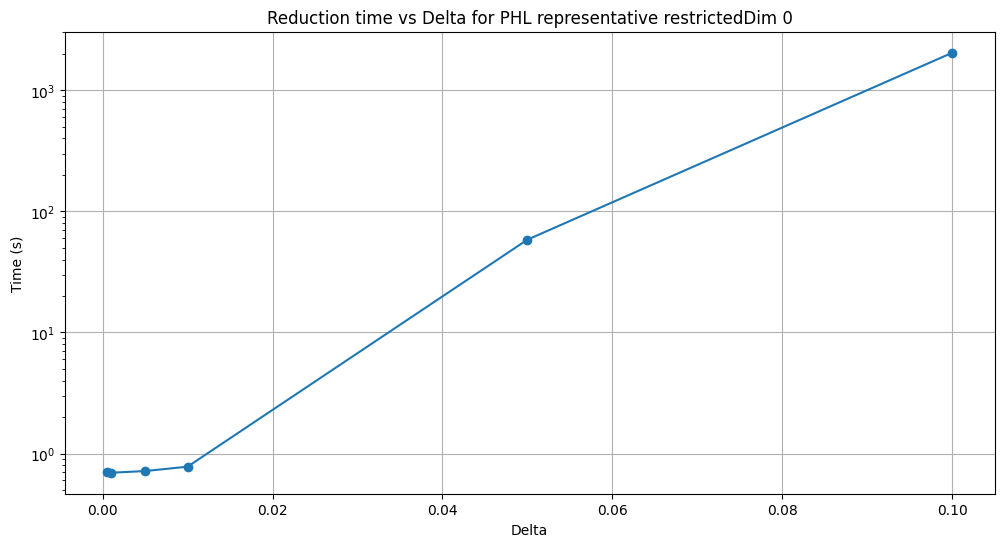

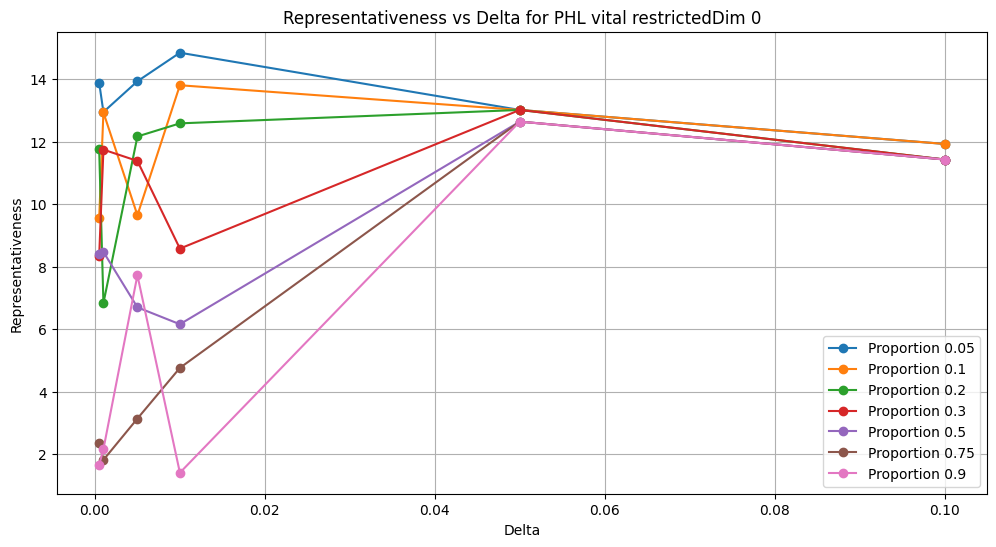

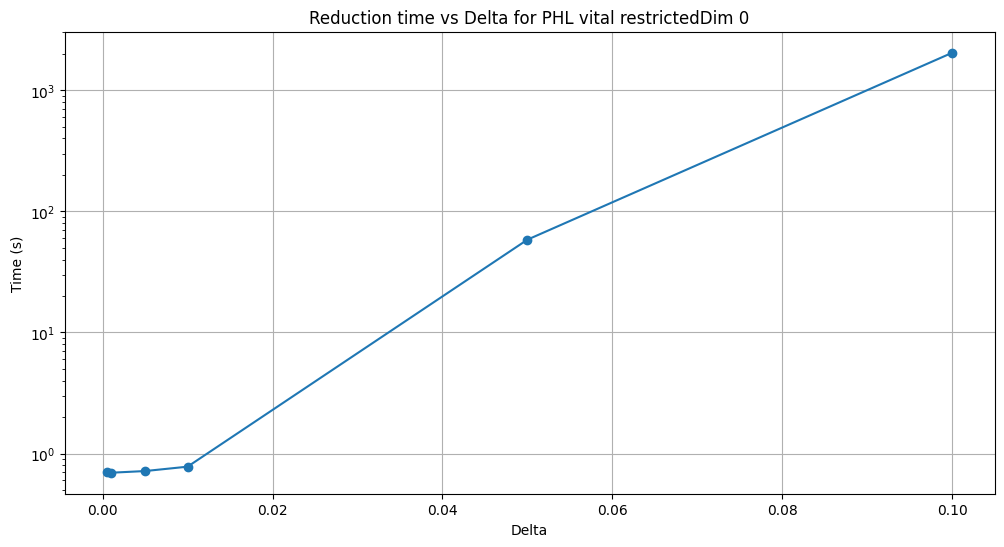

In [123]:
for mode in phl_results['mode'].unique():
    for dimension, scoring_version in phl_results[['max_dimension', 'dimensions']].drop_duplicates().values:
        # Get representativeness vs delta averaged by model
        mean_representativeness_phl = (
            phl_results[
                (phl_results['mode'] == mode) &
                (phl_results['dimensions'] == scoring_version) &
                (phl_results['max_dimension'] == dimension) &
                (phl_results['reduction_method'] == 'PHL')
            ]
            .groupby(['delta', 'percentage'])['representativeness']
            .mean()
            .reset_index()
        )
        # Get reduction time vs delta averaged by model
        mean_reduction_time_phl = (
            phl_results[
                (phl_results['mode'] == mode) &
                (phl_results['dimensions'] == scoring_version) &
                (phl_results['max_dimension'] == dimension)
            ]
            .groupby(['delta'])['reduction_time']
            .mean()
            .reset_index()
        )

        # Show representativeness vs delta for each percentage
        plt.figure(figsize=(12, 6))
        for percentage in phl_results['percentage'].unique():
            plt.plot(
                mean_representativeness_phl[mean_representativeness_phl['percentage'] == percentage]['delta'],
                mean_representativeness_phl[mean_representativeness_phl['percentage'] == percentage]['representativeness'],
                label=f'Proportion {percentage}', marker='o'
            )
        plt.title(f'Representativeness vs Delta for PHL {mode} {scoring_version} {dimension}')
        plt.xlabel('Delta')
        plt.ylabel('Representativeness')
        plt.legend()
        plt.grid()
        plt.savefig(f'{results_folder}/representativeness_vs_delta_{mode}_{scoring_version}_{dimension}.png')
        plt.show()

        # Show time vs delta
        plt.figure(figsize=(12, 6))
        plt.plot(
            mean_reduction_time_phl['delta'],
            mean_reduction_time_phl['reduction_time'], marker='o'
        )
        plt.title(f'Reduction time vs Delta for PHL {mode} {scoring_version} {dimension}')
        plt.xlabel('Delta')
        plt.ylabel('Time (s)')
        plt.yscale('log')
        plt.grid()
        plt.savefig(f'{results_folder}/reduction_time_vs_delta_{mode}_{scoring_version}_{dimension}.png')
        plt.show()

In [124]:
mean_reduction_time_phl

,delta,reduction_time
0,0.0005,0.702267
1,0.0010,0.695446
2,0.0050,0.717927
3,0.0100,0.780127
4,0.0500,58.403490
5,0.1000,2039.808212
